# DS4440 - Practical Neural Networks
## Week 2 : Image Classification using Multi Layer Perceptron

___
**Instructor** : Prof. Steve Schmidt <br/>
**Teaching Assistants** : Vishwajeet Hogale (hogale.v@northeastern.edu) | Chaitanya Agarwal (agarwal.cha@northeastern.edu)

## Problem Statement

Imagine we are working with the Fashion MNIST dataset, a collection of grayscale images representing various fashion items such as shirts, shoes, and bags. By analyzing features such as pixel intensity and patterns in the images, we can uncover insights into how models process and classify visual data.
<br/>

**Our goal is to take an image as an input and predict the class of the fashion item from the dataset.**
<br/>
We will demonstrate **both**:
- **Binary classification** (classes 0 vs. 1, i.e. T-shirt vs. Trouser)
- **Multi-class classification** (all 10 classes)
<br/>
To accomplish this goal, we will use the **Multi Layer Perceptron**.

<br/>


In this notebook, we'll follow the **six** key sections below:
1. **Data Gathering**
2. **Data Wrangling**
3. **Feature Understanding & Preprocessing**
4. **Model Building**
5. **Model Validation**
6. **Results and Conclusions**

Let's dive in and explore how neural networks can tackle this exciting problem!

## 0. Setup and Load libraries

The below cell helps you download all the necessary libraries or packages required to run this notebook without running into any errors.

In [113]:
import os
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(parent_dir)

In [114]:
! pip install -r ../../requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: '../../requirements.txt'


## 1. Data Gathering

### **About the Dataset**

The Fashion MNIST dataset consists of **70,000 labeled grayscale images**, each with a resolution of **28x28 pixels and 10 distinct classes**. This structured dataset allows us to experiment with building and training models, tuning hyperparameters, and evaluating performance.


Each training and test example is assigned to one of the following labels:

0 T-shirt/top<br/>
1 Trouser<br/>
2 Pullover<br/>
3 Dress<br/>
4 Coat<br/>
5 Sandal<br/>
6 Shirt<br/>
7 Sneaker<br/>
8 Bag<br/>
9 Ankle boot
<br/>
<br/>

**Dataset Source**
<br/>
The Fashion MNIST Dataset is a very popular dataset, which is already present in the torch library. What we're going to do is that we will fetch this dataset from torch and download it in our current working directory.
<br/><br/>

**What is the below cell doing?**<br/>
To build a model, it is very important to have a train and test split. Train split helps with training the model. And test split helps with evaluating the performance of the model. That's exactly what we've done below.

- train_dataset stores training images in a directory called as data used for training the model
- test_dataset stores testing images in a directory called as data used for evaluating the model



In [115]:
import torch
from torchvision import datasets, transforms

# Load the Fashion MNIST training and test datasets from torch
train_dataset = datasets.FashionMNIST(
    root='./data/train',  # Directory to download the dataset
    train=True,  # Load the training set
    download=True

)

test_dataset = datasets.FashionMNIST(
    root='./data/test',
    train=False,  # Load the test set
    download=True
)

### Visualize an image from the training dataset

Each image belongs to a fashion item that is given a class label.

In this instance,<br/>
**Ankle boot is represented by the class label 9.**



In [116]:
image, label = train_dataset[0]  # Access the first image and label
image, label

(<PIL.Image.Image image mode=L size=28x28>, 9)

To visualize the image, it should be converted to a numpy array so that visualization library can help display the image.

In [117]:
import numpy as np
image = np.array(image)

Display the image

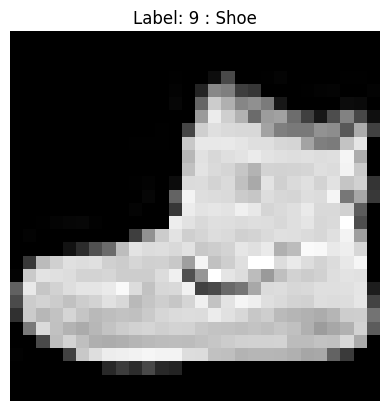

In [118]:
import matplotlib.pyplot as plt

plt.imshow(image, cmap='gray')
plt.title(f"Label: {label} : Shoe")
plt.axis('off')  # Turn off axes for clarity
plt.show()

## 2. Data Wrangling

### Check the size of the training dataset

In [119]:
num_images_train = len(train_dataset)
num_images_test = len(test_dataset)
print(f"The training dataset has {num_images_train} images")
print(f"The testing dataset has {num_images_test} images")

The training dataset has 60000 images
The testing dataset has 10000 images


### Explore the class distribution in all the fashion class labels

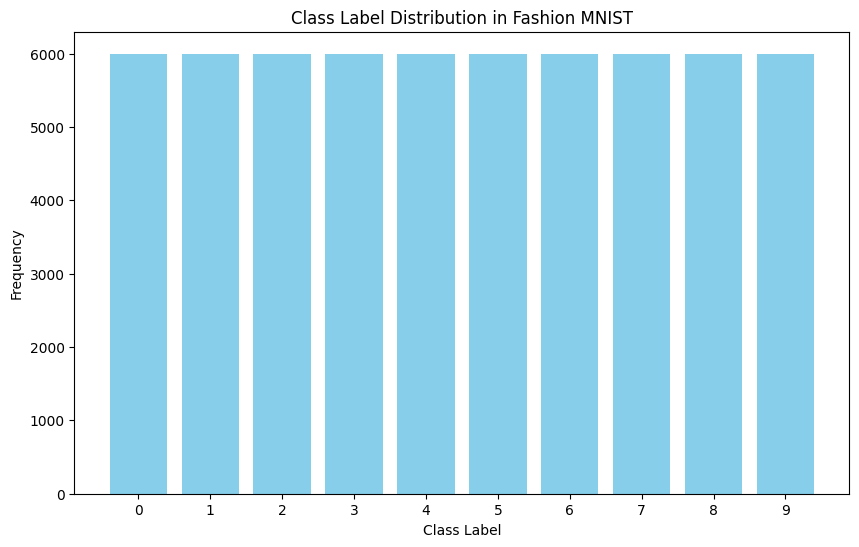

In [120]:
# Get the labels from the dataset
labels = np.array(train_dataset.targets)

# Count the occurrences of each class label (0 to 9)
unique_labels, counts = np.unique(labels, return_counts=True)

# Plot the class distribution as a bar chart
plt.figure(figsize=(10,6))
plt.bar(unique_labels, counts, color='skyblue')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Class Label Distribution in Fashion MNIST')
plt.xticks(unique_labels)  # Set x-ticks to be the class labels
plt.show()

#### Insights
- There are 6000 images in each fashion item class which makes it a well distributed dataset without any class imbalance.

## 3. Feature Understanding & Preprocessing

### Model Dataset creation
The following cell converts the **images in the data directory** into a **dataframe**, where **each row represents the pixel values of a 28x28 image which will be used by the MLP model**. For the purposes of this notebook, lets assume you were given the dataframe. You may choose to ignore the below two cells.


In [121]:
import pandas as pd


# function to convert the fashionMNIST dataset to a dataframe
# flattens each 28x28 image into 784 columns, plus 1 column for label => 'target'.

def build_df(dataset):
    num_samples = len(dataset)
    images = np.zeros((num_samples, 28 * 28), dtype=np.uint8)  # 28x28 flattened
    labels = np.zeros(num_samples, dtype=np.uint8)

    # Populate arrays in a single loop
    for i, (img_pil, label) in enumerate(dataset):
        images[i, :] = np.array(img_pil).flatten()  # Converts a 28 x 28 image into a 784 x 1 row in the dataset
        labels[i] = label

    # Convert to DataFrame
    df = pd.DataFrame(images)
    df['target'] = labels

    return df


In [122]:
# build DataFrames for train and test dataset
df_train = build_df(train_dataset)
df_test = build_df(test_dataset)

print("df_train shape:", df_train.shape, " 60,0000 images for training")  # expect (60000, 785)
print("df_test shape: ", df_test.shape, " 10,000 images for testing")   # expect (10000, 785)

df_train.head()

df_train shape: (60000, 785)  60,0000 images for training
df_test shape:  (10000, 785)  10,000 images for testing


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
1,0,0,0,0,0,1,0,0,0,0,...,114,130,76,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,22,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,33,96,...,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### **Modelling Tasks**
#### Binary Classification
In this task, we're going to pick any two classes from the fashion MNIST dataset and show how to use Binary Cross Entropy Loss for the binary predictions using MLP.

In [123]:
# Let's assume we only take fashion class 0 and 1 for binary classification
binary_classes = [0, 1]

# filter the training dataset on fashion class 0 and 1
train_mask = df_train['target'].isin(binary_classes) # This gets all rows that represent fashion items that belong to class 0 or 1

# Creates the dataframe that has only two fashion classes i.e 0 or 1.
df_train_bin = df_train[train_mask].copy()

# repeat for testing dataset
test_mask = df_test['target'].isin(binary_classes)
df_test_bin = df_test[test_mask].copy()

#### Multi-Class Classification
In this task, we're going to pick all the 10 classes from the fashion MNIST dataset and show how to use Cross Entropy Loss for the multi class predictions using MLP.

In [124]:
# multi-class DF: we keep all classes 0....9
df_train_multi = df_train.copy() # we create copies so that the original df is not disturbed. It's an optional step.
df_test_multi = df_test.copy()

Let's look at the shapes of the binary and multi-class datasets

In [125]:
print("Binary train shape:", df_train_bin.shape)
print("Binary test shape: ", df_test_bin.shape)
print("Multi-class train shape:", df_train_multi.shape)
print("Multi-class test shape: ", df_test_multi.shape)

Binary train shape: (12000, 785)
Binary test shape:  (2000, 785)
Multi-class train shape: (60000, 785)
Multi-class test shape:  (10000, 785)


The below cell helps you convert the dataframe into **numpy arrays** because torch models **cannot understand Series datatypes (dataframes)**
1. It uses all the 784 columns that we created by decomposing an image of size 28x28 as features (X) which the model will learn.
2. It uses the target column to predict the fashion class (y) an image belongs to.



In [126]:
# convert from DataFrame to X,y arrays
def df_to_numpy(df):
    # separate features from target
    X = df.drop(columns=['target']).values  # shape (N,784)
    y = df['target'].values  # shape (N,)
    return X, y

#### Train Test Split
This is an important step in model building. In the cells above, we created datasets for two tasks: Binary and Multi-class classification. For each of these tasks, we need to create a training split, which the model uses to learn, and a testing split, which the model uses to evaluate its performance.

In [127]:
X_train_bin, y_train_bin = df_to_numpy(df_train_bin)
X_test_bin, y_test_bin = df_to_numpy(df_test_bin)

# multi
X_train_multi, y_train_multi = df_to_numpy(df_train_multi)
X_test_multi, y_test_multi = df_to_numpy(df_test_multi)

print("Binary train:", X_train_bin.shape, y_train_bin.shape)
print("Multi train: ", X_train_multi.shape, y_train_multi.shape)

Binary train: (12000, 784) (12000,)
Multi train:  (60000, 784) (60000,)


In [128]:
# the data passed to the model will look like this:
X_train_bin

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [129]:
# to save the dataframe as a csv file, we can use:
#df.to_csv("Image_Dataset.csv")

## 4. Model Building

#### **Why are we creating batches ?**
As we all know, backpropagation occurs when all the rows of a dataset are passed through the model. In the backpropagation step, the model updates the weights after each epoch. This process continues until all epochs are completed.

Without batches, the model updates the weights at the end of every epoch, i.e., after the model has read all the rows in the dataset. With batches, the model processes a smaller subset of the data at a time. **This allows the model to update the weights more frequently, typically after each batch, which can lead to faster convergence.**

Additionally, **using batches helps in better generalization and can prevent overfitting by providing a more varied set of updates in each epoch. It also helps in reducing memory consumption when working with large datasets that cannot fit entirely into memory.**

In essence, batching improves computational efficiency and can lead to more stable and effective learning.


In [130]:
# function to manually create batches
def create_batches(X, y, batch_size=64, model=None):
    num_samples = len(X)
    for start in range(0, num_samples, batch_size):
        end = start + batch_size
        batch_X = X[start:end]
        batch_y = y[start:end]
        # convert to torch Tensors
        batch_X_t = torch.tensor(batch_X, dtype=torch.float32)
        # batch_X_t = batch_X.clone().detach().to(torch.float32)

        if model=="MultiClassMLP":
            batch_y_t = torch.tensor(batch_y, dtype=torch.long)
        else:
          batch_y_t = torch.tensor(batch_y, dtype=torch.float32) # For binary classification, the target (batch_y_t) is typically expected as a torch.float32 tensor
        yield batch_X_t, batch_y_t

#### Hyperparameters
Set your hyperparameters in this cell

In [131]:

import torch.nn as nn

lr = 0.0001 # learning rate
epochs = 10
batch_size = 64
num_classes = 10  # number of classes in FashionMNIST


activation = nn.ReLU()

print('Learning rate:', lr)
print('Batch size:', batch_size)
print('Number of epochs:', epochs)
print('Activation function:', activation)

Learning rate: 0.0001
Batch size: 64
Number of epochs: 10
Activation function: ReLU()


In [132]:
"""
    Binary MLP architecture for binary classification
        - Input Layer : 784 neurons
        - Activation Function : ReLU()
        - Hidden Layer : 64 neurons
        - Activation Function : Sigmoid()
        - Output Layer : 1 neuron

    - Predicts two classes
"""
class BinaryMLP(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.activation = activation
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.activation(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out  # shape (batch_size, 1)

display(BinaryMLP(784))

BinaryMLP(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (activation): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [133]:
"""
    MLP architecture for binary classification
        - Input Layer : 784 neurons
        - Activation Function : ReLU()
        - Hidden Layer : 128 neurons(by default)
        - Output Layer : 10 neurons

    - predicts 10 classes
"""
class MultiClassMLP(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.activation = activation
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.activation(out)
        out = self.fc2(out)
        return out

display(MultiClassMLP(784))

MultiClassMLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (activation): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

#### **What is the training loop doing?**

1. **Starting Training Mode**: We tell the model that it's time to learn, so we put it into "training mode."
2. **Going Through the Data**: We go through the data many times, just like reading a book over and over until we understand it better. Each time we go through the data, it’s called an **epoch**.
3. **Breaking the Data into Small Pieces**: Instead of reading the whole book at once, we break it into smaller pieces (called **batches**), so it’s easier for the model to learn from them one by one.
4. **Learning from Each Small Piece**:
   - For each small piece (or batch), we give it to the model to make a guess (this is the model's prediction).
   - We then check how close or far off the guess was from the actual answer (this is called **loss**).
   - The model learns from the mistake and gets a little better by adjusting itself (this is called **backpropagation**).
5. **Saving the Model**: After each round of learning, we save what the model has learned so far. If we stop in the middle, we can start again without losing progress.
6. **Repeat**: We do this again and again until the model gets better and better at making predictions.

After going through all the pieces many times, the model is saved one last time, and we have a trained model that can make good guesses!


In [134]:
# training loop
def train(model, X_train_np, y_train_np, loss_fn, optimizer, batch_size=64, epochs=5):
    model.train()
    num_samples = len(X_train_np)
    for epoch in range(epochs):
        total_loss = 0.0
        for X_batch_t, y_batch_t in create_batches(X_train_np, y_train_np, batch_size, model=model.__class__.__name__):
            outputs = model(X_batch_t)
            # for binary: shape (N,1), need .squeeze()
            loss = loss_fn(outputs.squeeze(), y_batch_t)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * len(X_batch_t)

        avg_loss = total_loss / num_samples
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")


        # save the model after every epoch (useful for longer training sessions)
        torch.save(model.state_dict(), model.__class__.__name__ + '.pth') # saves it as the model class' name
        print(f"Model saved.")                                            # example: "MultiClassMLP.pth"

    # save the model again after the final epoch
    torch.save(model.state_dict(), model.__class__.__name__ + '.pth')
    print(f"Final model saved.")

In [135]:
# if we want to load a model, we can use:
# model = torch.load("model.pth"))
# model.eval()

#### **Making Predictions with the Model**

The `predict` function helps the model guess things based on the data we give it. Here’s how it works, step by step:

1. **Get the Model Ready to Guess**:
   - We tell the model that it’s time to make guesses, not learn new things. This is called **evaluation mode**.

2. **Change the Data**:
   - If the data we give to the model is in a special format (called a NumPy array), we change it into something the model can understand (called a tensor).

3. **Don’t Keep Track of Learning**:
   - We tell the model not to remember anything while making predictions. This saves time and makes the prediction faster.

4. **Chop the Data into Pieces**:
   - If we have a lot of data, we break it into smaller chunks (called **batches**) so the model can handle it better.

5. **Let the Model Make Guesses**:
   - For each chunk of data, the model looks at it and tries to guess the answer.

6. **Pick the Best Guess**:
   - After looking at the data, the model picks the best guess (the one with the highest score).

7. **Keep All the Guesses**:
   - We save all the guesses the model makes for later.

8. **Return the Guesses**:
   - Once all the guesses are made, we give them back as a list for us to see.

This function helps the model make lots of guesses, one batch at a time, without learning anything new.


In [136]:
# model inference
def predict(model, X, batch_size):
    model.eval()  # set the model to evaluation mode
    predictions = []

    # if X is a NumPy array, convert it to a PyTorch tensor
    if isinstance(X, np.ndarray):
        X = torch.tensor(X, dtype=torch.float32)

    with torch.no_grad():  # disable gradient computation for inference
        for X_batch, _ in create_batches(X, np.zeros(len(X)), batch_size, model=model):  # Use dummy labels
            outputs = model(X_batch)  # forward pass
            predicted_classes = torch.argmax(outputs, dim=1)  # get predicted class index
            predictions.extend(predicted_classes.numpy())  # convert to NumPy and append

    return np.array(predictions)

### Binary MLP runner
This cells calls the train functions defined in the above cells

In [137]:
import torch.optim as optim # torch package implementing various optimization algorithms

input_size = X_train_bin.shape[1]  # number of features in each sample
binary_mlp = BinaryMLP(input_size)       # creating an object of the MLP model class
optimizer = optim.SGD(binary_mlp.parameters(), lr=lr) # stochastic gradient descent as optimizer
loss_fn = nn.BCELoss()


train(binary_mlp, X_train_bin, y_train_bin, loss_fn, optimizer, batch_size=batch_size, epochs=epochs)

Epoch [1/10] - Loss: 0.5106
Model saved.
Epoch [2/10] - Loss: 0.1487
Model saved.
Epoch [3/10] - Loss: 0.1180
Model saved.
Epoch [4/10] - Loss: 0.1005
Model saved.
Epoch [5/10] - Loss: 0.0884
Model saved.
Epoch [6/10] - Loss: 0.0797
Model saved.
Epoch [7/10] - Loss: 0.0726
Model saved.
Epoch [8/10] - Loss: 0.0670
Model saved.
Epoch [9/10] - Loss: 0.0551
Model saved.
Epoch [10/10] - Loss: 0.0509
Model saved.
Final model saved.


### Multi-class MLP runner

In [138]:
input_size = X_train_multi.shape[1]  # number of features in each sample
multi_mlp = MultiClassMLP(input_size)       # creating an object of the multi-class MLP model
optimizer = optim.SGD(multi_mlp.parameters(), lr=lr) # stochastic gradient descent as optimizer
loss_fn = nn.CrossEntropyLoss()


train(multi_mlp, X_train_multi, y_train_multi, loss_fn, optimizer, batch_size=batch_size, epochs=epochs)

Epoch [1/10] - Loss: 1.8266
Model saved.
Epoch [2/10] - Loss: 0.7153
Model saved.
Epoch [3/10] - Loss: 0.5980
Model saved.
Epoch [4/10] - Loss: 0.5449
Model saved.
Epoch [5/10] - Loss: 0.5118
Model saved.
Epoch [6/10] - Loss: 0.4879
Model saved.
Epoch [7/10] - Loss: 0.4696
Model saved.
Epoch [8/10] - Loss: 0.4547
Model saved.
Epoch [9/10] - Loss: 0.4422
Model saved.
Epoch [10/10] - Loss: 0.4315
Model saved.
Final model saved.


## 5. Model Validation

#### **Looking at the Model's Predictions**

The `analyze_predictions` function helps us understand how well our model is doing by showing us the **correct** and **incorrect** guesses it made. Here's how it works:

1. **Change the Data**:
   - The test data (X_test) is of numpy format, and in this cell we can't add acolumns like true_label or predicted_label. So, we convert this numpy array into a Series dataframe.
   - If the test data (X_test) is in a special format that the model can't easily read, we change it into a table (called a **DataFrame**).

2. **Make Sure the Labels are Ready**:
   - We check if the true answers (**y_test**) and the guesses (**y_pred**) are in the right format. If they’re not, we turn them into a simple list.

3. **Add the Guesses to the Data**:
   - We add the real answers (**true_label**) and the guesses (**predicted_label**) to our table, so we can compare them.

4. **Find the Correct and Wrong Guesses**:
   - We look at the table and find which guesses were correct and which ones were wrong.

5. **Show Some Examples**:
   - We pick a few examples (3 at most) of both **correct guesses** and **wrong guesses** and show them to you. This helps us see how the model is doing.

6. **Print the Results**:
   


In [139]:
# creating a dictionary of class labels and what the represent
class_labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

In [140]:
random_state = 999 # you can play around with this to sample different examples.
# we usually decide on a number for reproducibility.


def analyze_predictions(X_test, y_test, y_pred, task="binary"):
    # Convert X_test to DataFrame if it's a NumPy array or PyTorch tensor
    if isinstance(X_test, (np.ndarray, torch.Tensor)):
        X_test = pd.DataFrame(X_test)

    # Ensure y_test and y_pred are in the correct format
    if isinstance(y_test, (np.ndarray, torch.Tensor)):
        y_test = pd.Series(y_test)
    if isinstance(y_pred, (np.ndarray, torch.Tensor)):
        y_pred = pd.Series(y_pred)

    # Add true and predicted labels to X_test
    X_test['true_label'] = y_test
    X_test['predicted_label'] = y_pred

    # Identify correct and incorrect predictions
    correct_preds = X_test[X_test['true_label'] == X_test['predicted_label']]
    incorrect_preds = X_test[X_test['true_label'] != X_test['predicted_label']]

    # Sample examples for correct and incorrect predictions
    correct_examples = correct_preds.sample(n=min(3, len(correct_preds)), random_state=random_state)
    incorrect_examples = incorrect_preds.sample(n=min(3, len(incorrect_preds)), random_state=random_state)

    print("\nCorrect Predictions:")
    display(correct_examples)

    print("\nIncorrect Predictions:")
    display(incorrect_examples)

    print("-"*40)


    return [correct_examples, incorrect_examples]

In [141]:
# running inference on test set
y_pred_bin = predict(binary_mlp, X_test_bin, batch_size)
y_pred_multi = predict(multi_mlp, X_test_multi, batch_size)

# analyze binary predictions
print("Binary Classification: ")
binary_results = analyze_predictions(X_test_bin, y_test_bin, y_pred_bin, task="binary")

<ipython-input-130-fdd6653ce9f5>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_X_t = torch.tensor(batch_X, dtype=torch.float32)


Binary Classification: 

Correct Predictions:


,0,1,2,3,4,5,6,7,8,9,...,776,777,778,779,780,781,782,783,true_label,predicted_label
1668,0,0,0,0,0,2,0,0,0,0,...,46,1,0,0,1,1,0,0,0,0
135,0,0,0,0,0,0,0,0,0,92,...,136,130,0,0,0,0,0,0,0,0
626,0,0,0,2,0,2,2,0,0,0,...,178,143,0,0,2,0,0,0,0,0



Incorrect Predictions:


,0,1,2,3,4,5,6,7,8,9,...,776,777,778,779,780,781,782,783,true_label,predicted_label
1696,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
139,0,0,0,0,0,0,0,0,0,34,...,0,0,0,0,0,0,0,0,1,0
610,0,0,0,0,0,0,0,0,0,181,...,0,0,0,0,0,0,0,0,1,0


----------------------------------------


### Now, lets visualize the predictions.


In [142]:
def visualize_predictions(correct_examples, incorrect_examples):
    # combine for plotting
    all_samples = pd.concat([correct_examples, incorrect_examples]).reset_index(drop=True)
    total_samples = len(all_samples)

    total_samples = len(all_samples)

    if total_samples == 0:
        print("No samples to plot.")
        return

    # we fix 2 rows, 3 columns -> up to 6 images
    # first row = correct examples, second row = incorrect examples.
    rows = 2
    cols = 3
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))

    # flatten the 2D array of axes into a 1D list for easy indexing
    axes_flat = axes.ravel()

    # if we have more than 6 samples, we'll just take the first 6
    max_plots = rows * cols
    num_plots = min(total_samples, max_plots)

    # for each row in the DataFrame, up to num_plots
    for i, (idx, row) in enumerate(all_samples.iloc[:num_plots].iterrows()):
        pixel_values = row.iloc[:784].values  # shape (784,)
        img_2d = pixel_values.reshape(28, 28)

        true_lbl = row['true_label']
        pred_lbl = row['predicted_label']

        ax = axes_flat[i]
        ax.imshow(img_2d, cmap='gray')
        ax.set_title(f"True:{true_lbl} ({class_labels[true_lbl]})\nPredicted:{pred_lbl} ({class_labels[pred_lbl]})")
        ax.axis('off')

    # turn off any leftover axes if there are fewer than 6 samples
    for j in range(num_plots, max_plots):
        axes_flat[j].axis('off')

    plt.tight_layout()
    plt.show()

    plt.tight_layout()
    plt.show()

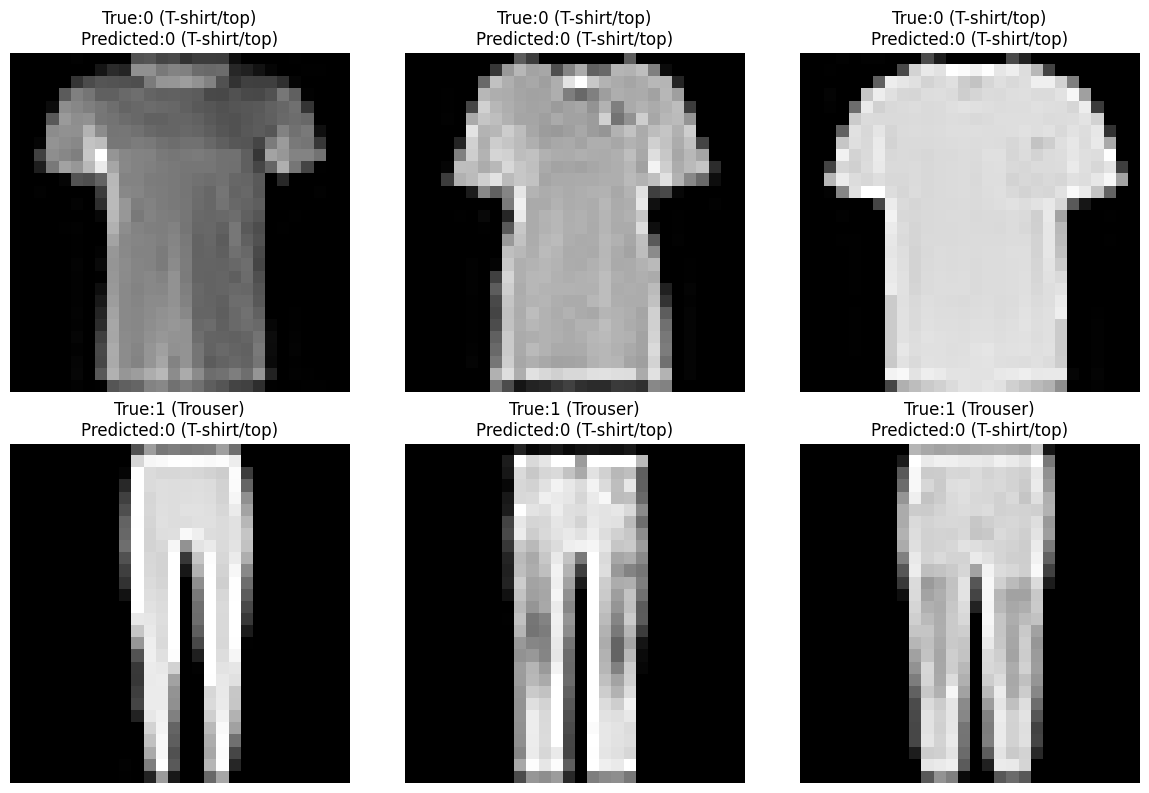

<Figure size 640x480 with 0 Axes>

In [143]:
visualize_predictions(binary_results[0], binary_results[1])

In [144]:
print("Multi-Class Classification")
multi_results = analyze_predictions(X_test_multi, y_test_multi, y_pred_multi, task="multiclass")

Multi-Class Classification

Correct Predictions:


,0,1,2,3,4,5,6,7,8,9,...,776,777,778,779,780,781,782,783,true_label,predicted_label
2264,0,0,3,1,0,1,0,0,0,0,...,35,0,0,0,0,0,0,0,0,0
3137,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
5952,0,0,0,0,0,0,33,158,205,142,...,81,72,34,0,3,0,0,0,6,6



Incorrect Predictions:


,0,1,2,3,4,5,6,7,8,9,...,776,777,778,779,780,781,782,783,true_label,predicted_label
4071,0,0,0,0,0,0,0,0,19,85,...,130,58,0,0,0,0,1,0,8,6
6007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,3
8618,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,6


----------------------------------------


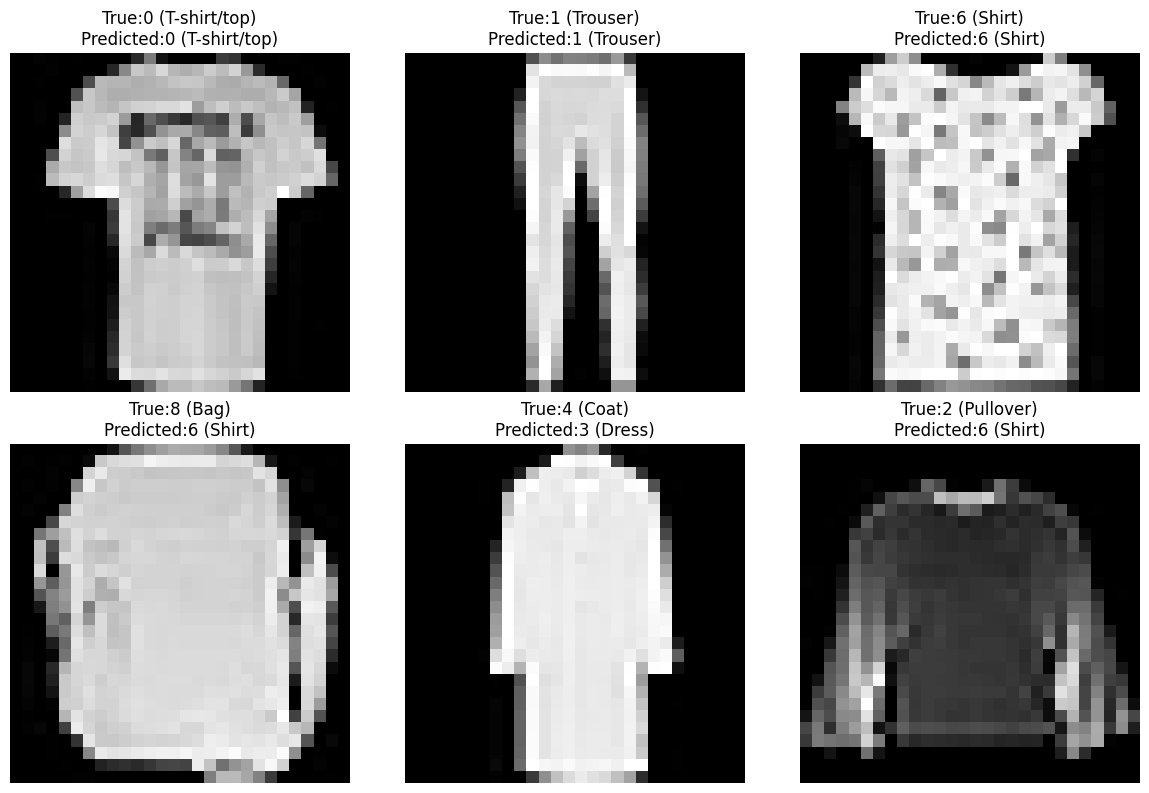

<Figure size 640x480 with 0 Axes>

In [145]:
visualize_predictions(multi_results[0], multi_results[1])

## 6. Results

Using confusion matrix to evaluate the model.

In [146]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import torch

def evaluate(model, X_test, y_test, task="binary", threshold=0.5):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        # convert test features to PyTorch tensors
        X_test_t = torch.tensor(X_test, dtype=torch.float32)

        # get model outputs
        outputs = model(X_test_t)

        if task == "binary":
            # for binary classification, apply threshold
            preds = (outputs.squeeze().numpy() >= threshold).astype(int)
        elif task == "multiclass":
            # for multi-class classification, get the class with the highest score
            preds = torch.argmax(outputs, dim=1).numpy()
        else:
            raise ValueError(f"Unsupported task type: {task}. Use 'binary' or 'multiclass'.")

    # calculate accuracy and confusion matrix
    accuracy = accuracy_score(y_test, preds)
    cm = confusion_matrix(y_test, preds)

    return accuracy, cm


Binary Test Accuracy: 0.978
Binary Confusion Matrix:


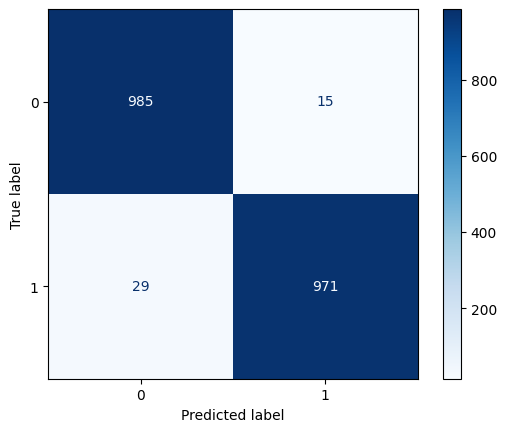

In [147]:
# confusion Matrix for binary classification:
# [[TN, FP],
# [FN, TP]]
accuracy_bin, cm_bin = evaluate(binary_mlp, X_test_bin, y_test_bin, task="binary")
print("\nBinary Test Accuracy:", accuracy_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bin, display_labels=['0', '1'])
print("Binary Confusion Matrix:")
disp.plot(cmap=plt.cm.Blues)
plt.show()


Multi-Class Test Accuracy: 0.8331
Multi-Class Confusion Matrix:


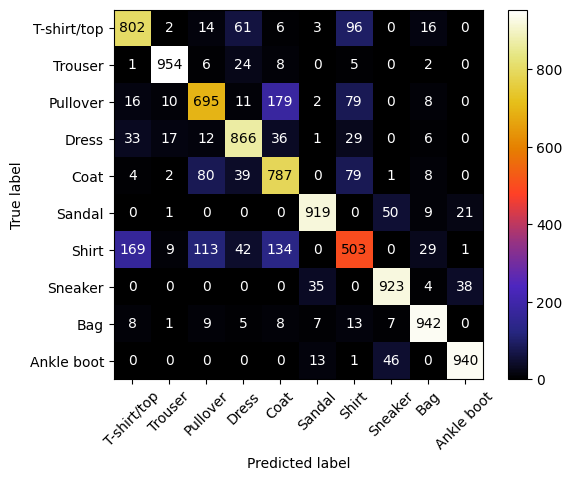

In [157]:
# multi-class classification
accuracy_multi, cm_multi = evaluate(multi_mlp, X_test_multi, y_test_multi, task="multiclass")
print("\nMulti-Class Test Accuracy:", accuracy_multi)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_multi, display_labels=list(class_labels.values()))
print("Multi-Class Confusion Matrix:")
disp.plot(cmap=plt.cm.CMRmap)
plt.xticks(rotation=45) # rotating the x-axis labels at angle so they are legible
plt.show()